In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect

In [2]:
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

#ONLY DOING THIS because idk what this database looks like
inspector = inspect(engine)
print(inspector.get_table_names())

['measurement', 'station']


In [3]:
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [4]:
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [5]:
#test query to make sure data can be pulled
query = """
        Select 
            *
        from
            station
        limit 100
        """

In [6]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

In [7]:
df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Precipitation Analysis

In [8]:
query = """
       SELECT
            date, 
            prcp
        FROM
            measurement
        ORDER BY
            date
        """

In [9]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

In [10]:
df["date"] = pd.to_datetime(df["date"])
maxDate = df.loc[len(df) - 1, "date"]

startDate = maxDate - datetime.timedelta(days=365)
#laat yr filter
df_sub = df.loc[df["date"] >= startDate].reset_index(drop=True)
df_sub.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


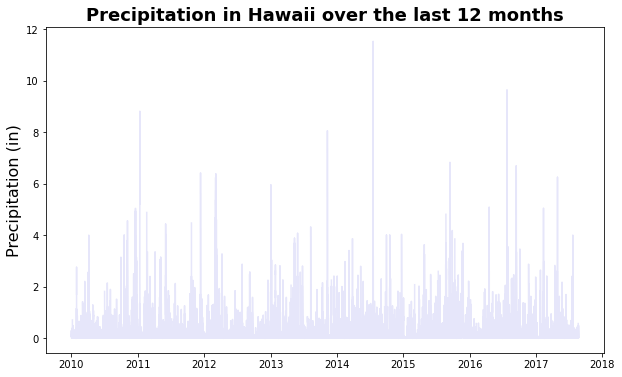

In [12]:
plt.figure(figsize=(10,6))
plt.plot(df.date, df.prcp, color="#E6E6FA")
plt.title("Precipitation in Hawaii over the last 12 months", fontweight="bold", fontsize=18)
plt.ylabel("Precipitation (in)", fontsize=16)
plt.xlabel("")

plt.show()

In [13]:
df_sub.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Stations

In [14]:
query = """
        SELECT
            count(*) as station_count
        FROM
            station
        """

In [15]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,station_count
0,9


In [16]:
query = """
        SELECT
        s.station,
        count(*) as tot_obs
        FROM
            station s
        JOIN measurement m on s.station = m.station
        GROUP BY s.station
        ORDER BY
            count(*) desc
        """

In [17]:
 conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,station,tot_obs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [18]:
 query = """
        SELECT
            m.date,
            m.prcp,
            m.tobs,
            s.station
        FROM
            measurement m
            join station s on m.station = s.station
        WHERE
            date >= (
                        SELECT
                           date(MAX(date), '-365 day')
                        FROM
                            measurement
                    )
        ORDER BY
            date
        """

In [19]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,date,prcp,tobs,station
0,2016-08-23,0.00,81.0,USC00519397
1,2016-08-23,0.15,76.0,USC00513117
2,2016-08-23,0.05,80.0,USC00514830
3,2016-08-23,NaN,80.0,USC00517948
4,2016-08-23,0.02,80.0,USC00519523
...,...,...,...,...
2225,2017-08-22,0.50,76.0,USC00516128
2226,2017-08-23,0.00,81.0,USC00519397
2227,2017-08-23,0.00,82.0,USC00514830
2228,2017-08-23,0.08,82.0,USC00519523


In [20]:
 df.groupby("station").size().sort_values(ascending=False)

station
USC00519397    361
USC00519281    352
USC00516128    349
USC00513117    343
USC00519523    337
USC00514830    305
USC00517948    183
dtype: int64

In [21]:
mostActive = df.groupby("station").size().sort_values(ascending=False).index[1]
mostActive

'USC00519281'

In [22]:
df_sub = df.loc[df.station == mostActive].reset_index(drop=True)

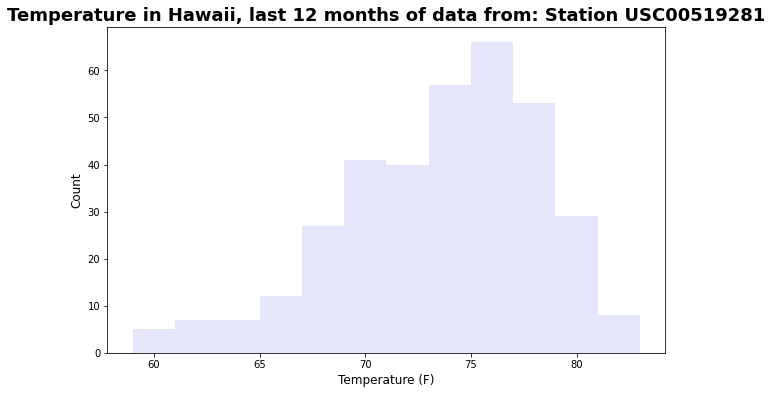

In [23]:
plt.figure(figsize=(10,6))
plt.hist(df_sub.tobs, bins=12, color="#E6E6FA")
plt.title(f"Temperature in Hawaii, last 12 months of data from: Station {mostActive}", fontweight="bold", fontsize=18)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Temperature (F)", fontsize=12)

plt.show()

In [24]:
df_sub.describe()

,prcp,tobs
count,352.000000,352.000000
mean,0.198949,73.107955
std,0.419182,4.733315
min,0.000000,59.000000
25%,0.000000,70.000000
50%,0.060000,74.000000
75%,0.190000,77.000000
max,2.980000,83.000000
